# Fine-tuning of the model

In [177]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle

from tensorflow import keras

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img

from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import Model
from keras.optimizers import Adam

from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.mobilenet_v2 import decode_predictions

In [149]:
CSV_PATH = '../data/pokemon.csv'
IMAGES_FOLDER = '../data/images/images'
IMG_WIDTH, IMG_HEIGHT = 128,128
NB_CLASSES = 18
BATCH_SIZE = 32
EPOCHS = 300

df = pd.read_csv(CSV_PATH)

def merge_types(row): 
    t1 = row['Type1']
    t2 = row['Type2']
    if t2 is np.nan: 
        return [t1]
    return [t1,t2]

def find_image_path_with_name(_name):
    if os.path.exists(os.path.join(IMAGES_FOLDER, _name+'.png')):
        return _name + '.png'
    else:
        return _name + '.jpg'

df['labels'] = df.apply(lambda row: merge_types(row), axis=1)
df['path'] = df.apply(lambda row: find_image_path_with_name(row['Name']), axis=1)

In [150]:
df.head()

,Name,Type1,Type2,labels,path
0,bulbasaur,Grass,Poison,"[Grass, Poison]",bulbasaur.png
1,ivysaur,Grass,Poison,"[Grass, Poison]",ivysaur.png
2,venusaur,Grass,Poison,"[Grass, Poison]",venusaur.png
3,charmander,Fire,NaN,[Fire],charmander.png
4,charmeleon,Fire,NaN,[Fire],charmeleon.png


## Data Loading

In [164]:
datagen = ImageDataGenerator(rescale=1./255)

temp_df, test_df = train_test_split(df, train_size=0.9, random_state=42) #temp_df will be used for cross-validation
train_df, validation_df =  train_test_split(temp_df, test_size=0.2, random_state=42)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_FOLDER,
    x_col='path',
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    validate_filenames=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=IMAGES_FOLDER,
    x_col='path',
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    validate_filenames=True
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMAGES_FOLDER,
    x_col='path',
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    validate_filenames=True
)

Found 582 validated image filenames belonging to 18 classes.
Found 146 validated image filenames belonging to 18 classes.
Found 81 validated image filenames belonging to 18 classes.


## Data augmentation

In order to increase the dataset, to balance the weight of the classes and to avoid overfitting, let's add 1000 images thank's to geometrical operations on the images already in our dataset. 

In [166]:
data_augment_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmentation_generator = data_augment_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_FOLDER,
    x_col='path', 
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

nb_augmented_images = 1000
nb_batches = nb_augmented_images // BATCH_SIZE

for i in range(nb_batches):
    augmented_images, classes_images = augmentation_generator.next()
    
    for idx, img_array in enumerate(augmented_images):
        img = array_to_img(img_array)
        img.save(f"{IMAGES_FOLDER}/augmented_img_{i * BATCH_SIZE + idx}.png")
        
        # convert binary classes (ex: [0,0,1,...,0]) to labels (ex: [Fire, Normal])
        class_indices = [index for index, value in enumerate(classes_img[idx]) if value == 1]
        class_labels = [list(train_generator.class_indices)[class_id] for class_id in class_indices]

        new_row = {'path': f"augmented_img_{i * BATCH_SIZE + idx}.png", 'labels': class_labels}
        train_df = train_df.append(new_row, ignore_index=True)

Found 582 validated image filenames belonging to 18 classes.


/home/omar/anaconda3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(new_row, ignore_index=True)
/tmp/ipykernel_4649/601236336.py:37: FutureWarning: The frame.append method is deprecated an

In [167]:
train_df

,Name,Type1,Type2,labels,path
0,pidgeotto,Normal,Flying,"[Normal, Flying]",pidgeotto.png
1,farfetchd,Normal,Flying,"[Normal, Flying]",farfetchd.png
2,dugtrio,Ground,NaN,[Ground],dugtrio.png
3,luxray,Electric,NaN,[Electric],luxray.png
4,minccino,Normal,NaN,[Normal],minccino.png
...,...,...,...,...,...
1543,NaN,NaN,NaN,"[Dark, Fighting]",augmented_img_987.png
1544,NaN,NaN,NaN,[Normal],augmented_img_988.png
1545,NaN,NaN,NaN,"[Fairy, Flying]",augmented_img_989.png
1546,NaN,NaN,NaN,"[Fighting, Normal]",augmented_img_990.png


In [168]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_FOLDER,
    x_col='path',
    y_col='labels',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode='categorical',
    validate_filenames=True,
    classes=train_generator.class_indices,
)

Found 1548 validated image filenames belonging to 18 classes.


/home/omar/anaconda3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


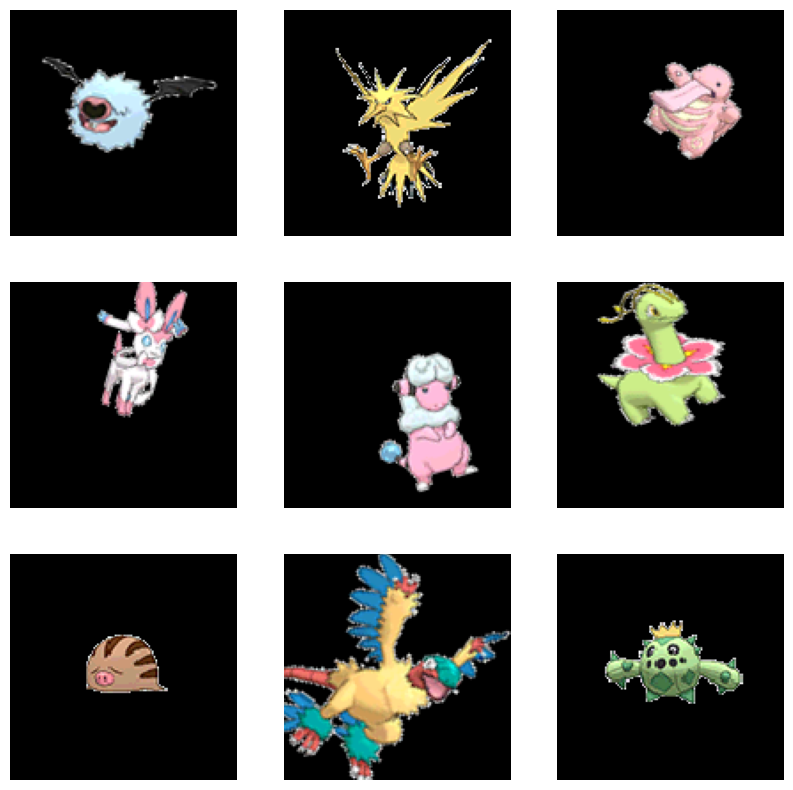

In [169]:
augmented_images, _ = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

## First training

In [173]:
model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

x = GlobalAveragePooling2D()(model.output)
x = Dropout(0.5)(x) #regularisation
predictions = Dense(NB_CLASSES, activation='sigmoid')(x)

for layer in model.layers:
    layer.trainable = False
    
model = Model(inputs=model.input, outputs=predictions)

model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=10, verbose=0
)

model_info = model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/300
49/49 [==============================] - 13s 217ms/step - loss: 0.4071 - accuracy: 0.0769 - val_loss: 0.3071 - val_accuracy: 0.0890
Epoch 2/300
49/49 [==============================] - 10s 202ms/step - loss: 0.3443 - accuracy: 0.0872 - val_loss: 0.2958 - val_accuracy: 0.1164
Epoch 3/300
49/49 [==============================] - 9s 193ms/step - loss: 0.3198 - accuracy: 0.1156 - val_loss: 0.2889 - val_accuracy: 0.1164
Epoch 4/300
49/49 [==============================] - 10s 203ms/step - loss: 0.3050 - accuracy: 0.1350 - val_loss: 0.2779 - val_accuracy: 0.1438
Epoch 5/300
49/49 [==============================] - 10s 201ms/step - loss: 0.2954 - accuracy: 0.1357 - val_loss: 0.2816 - val_accuracy: 0.1233
Epoch 6/300
49/49 [==============================] - 10s 196ms/step - loss: 0.2839 - accuracy: 0.1512 - val_loss: 0.2817 - val_accuracy: 0.1164
Epoch 7/300
49/49 [==============================] - 10s 199ms/step - loss: 0.2737 - accuracy: 0.1815 - val_loss: 0.2753 - val_accuracy: 

3/3 - 0s - loss: 0.3134 - accuracy: 0.1728 - 480ms/epoch - 160ms/step


Loss on test set : 0.313 ; Categorical accuracy on test set : 0.173


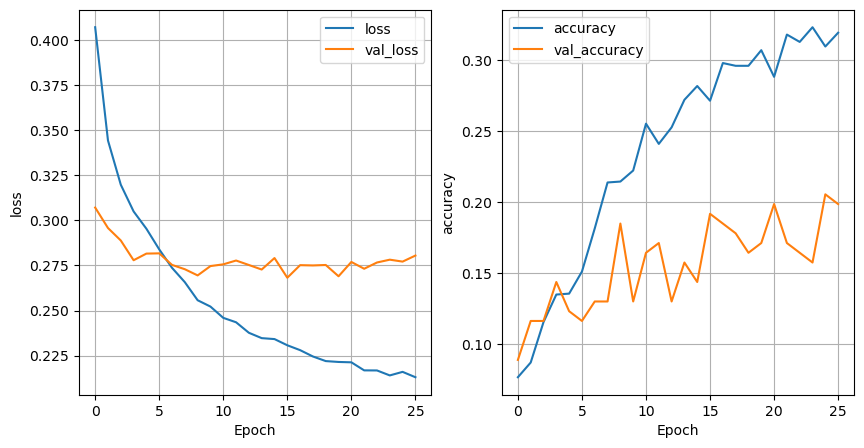

In [174]:
keys = list(model_info.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)

for idx, ax in enumerate(axes): 

    axes[idx].plot(model_info.history[keys[idx]], label=keys[idx])
    axes[idx].plot(model_info.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()
    axes[idx].grid(True)

test_loss, test_acc = model.evaluate(test_generator, verbose=2); 
print("\n\nLoss on test set : {:.3} ; Categorical accuracy on test set : {:.3f}".format(test_loss, test_acc))

The model is less successful on the training dataset.

## Cross-validation

Let's implement a K-Fold cross-validation (k=5) without the data augmentation.

In [183]:
df_shuffled = shuffle(temp_df, random_state=42) #temp_df contains train_df and test_df
cross_datagen = ImageDataGenerator(rescale=1./255)

nb_folds = 5
fold_size = len(df_shuffled) // nb_folds

for fold in range(nb_folds):
    print(f"\nFold {fold + 1}/{nb_folds}")

    start_id = fold * fold_size
    end_id = (fold + 1) * fold_size if fold < nb_folds - 1 else len(df_shuffled)

    val_data_fold = df_shuffled.iloc[start_id:end_id]
    train_data_fold = pd.concat([df_shuffled.iloc[:start_id], df_shuffled.iloc[end_id:]])

    train_generator = cross_datagen.flow_from_dataframe(
        dataframe=train_data_fold,
        directory=IMAGES_FOLDER,
        x_col='path',
        y_col='labels',
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        validate_filenames=True
    )

    val_generator = cross_datagen.flow_from_dataframe(
        dataframe=val_data_fold,
        directory=IMAGES_FOLDER,
        x_col='path',
        y_col='labels',
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        validate_filenames=True
    )
    
    model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    x = GlobalAveragePooling2D()(model.output)
    x = Dropout(0.5)(x)
    predictions = Dense(NB_CLASSES, activation='sigmoid')(x)

    for layer in model.layers:
        layer.trainable = False
    
    model = Model(inputs=model.input, outputs=predictions)

    model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',patience=10, verbose=0
    )

    model.fit(
        train_generator,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=val_generator,
        callbacks=[early_stopping]
    )

    test_loss, test_acc = model.evaluate(test_generator, verbose=0); 
    print(f"Test Accuracy for Fold {fold + 1}: {test_acc}")


Fold 1/5
Found 583 validated image filenames belonging to 18 classes.
Found 145 validated image filenames belonging to 18 classes.
Epoch 1/300


/home/omar/anaconda3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


19/19 [==============================] - 8s 271ms/step - loss: 0.4800 - accuracy: 0.0669 - val_loss: 0.3619 - val_accuracy: 0.0759
Epoch 2/300
19/19 [==============================] - 4s 229ms/step - loss: 0.3645 - accuracy: 0.1098 - val_loss: 0.3125 - val_accuracy: 0.1103
Epoch 3/300
19/19 [==============================] - 4s 231ms/step - loss: 0.3284 - accuracy: 0.1269 - val_loss: 0.2919 - val_accuracy: 0.1310
Epoch 4/300
19/19 [==============================] - 4s 224ms/step - loss: 0.3070 - accuracy: 0.1630 - val_loss: 0.2921 - val_accuracy: 0.1448
Epoch 5/300
19/19 [==============================] - 4s 227ms/step - loss: 0.2956 - accuracy: 0.1750 - val_loss: 0.2827 - val_accuracy: 0.1655
Epoch 6/300
19/19 [==============================] - 4s 234ms/step - loss: 0.2752 - accuracy: 0.2264 - val_loss: 0.2785 - val_accuracy: 0.2207
Epoch 7/300
19/19 [==============================] - 4s 229ms/step - loss: 0.2628 - accuracy: 0.2350 - val_loss: 0.2747 - val_accuracy: 0.1862
Epoch 8/300

/home/omar/anaconda3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


19/19 [==============================] - 8s 273ms/step - loss: 0.4690 - accuracy: 0.0583 - val_loss: 0.4048 - val_accuracy: 0.0897
Epoch 2/300
19/19 [==============================] - 5s 242ms/step - loss: 0.3700 - accuracy: 0.0909 - val_loss: 0.3275 - val_accuracy: 0.0828
Epoch 3/300
19/19 [==============================] - 5s 240ms/step - loss: 0.3239 - accuracy: 0.0995 - val_loss: 0.3144 - val_accuracy: 0.1034
Epoch 4/300
19/19 [==============================] - 4s 222ms/step - loss: 0.3062 - accuracy: 0.1424 - val_loss: 0.3041 - val_accuracy: 0.1310
Epoch 5/300
19/19 [==============================] - 5s 249ms/step - loss: 0.2914 - accuracy: 0.1664 - val_loss: 0.2985 - val_accuracy: 0.1448
Epoch 6/300
19/19 [==============================] - 4s 220ms/step - loss: 0.2654 - accuracy: 0.2298 - val_loss: 0.2949 - val_accuracy: 0.1448
Epoch 7/300
19/19 [==============================] - 4s 219ms/step - loss: 0.2547 - accuracy: 0.2196 - val_loss: 0.2916 - val_accuracy: 0.1655
Epoch 8/300

/home/omar/anaconda3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


19/19 [==============================] - 6s 230ms/step - loss: 0.4787 - accuracy: 0.0583 - val_loss: 0.3745 - val_accuracy: 0.1172
Epoch 2/300
19/19 [==============================] - 3s 180ms/step - loss: 0.3658 - accuracy: 0.1063 - val_loss: 0.3187 - val_accuracy: 0.1379
Epoch 3/300
19/19 [==============================] - 3s 179ms/step - loss: 0.3180 - accuracy: 0.1029 - val_loss: 0.2973 - val_accuracy: 0.1379
Epoch 4/300
19/19 [==============================] - 3s 180ms/step - loss: 0.2982 - accuracy: 0.1458 - val_loss: 0.2952 - val_accuracy: 0.1379
Epoch 5/300
19/19 [==============================] - 4s 186ms/step - loss: 0.2784 - accuracy: 0.1784 - val_loss: 0.2914 - val_accuracy: 0.1517
Epoch 6/300
19/19 [==============================] - 4s 203ms/step - loss: 0.2672 - accuracy: 0.1973 - val_loss: 0.2892 - val_accuracy: 0.1379
Epoch 7/300
19/19 [==============================] - 4s 200ms/step - loss: 0.2567 - accuracy: 0.2298 - val_loss: 0.2882 - val_accuracy: 0.1448
Epoch 8/300

/home/omar/anaconda3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


19/19 [==============================] - 6s 212ms/step - loss: 0.5138 - accuracy: 0.0583 - val_loss: 0.3811 - val_accuracy: 0.0414
Epoch 2/300
19/19 [==============================] - 4s 185ms/step - loss: 0.3661 - accuracy: 0.0858 - val_loss: 0.3176 - val_accuracy: 0.0966
Epoch 3/300
19/19 [==============================] - 4s 190ms/step - loss: 0.3288 - accuracy: 0.1184 - val_loss: 0.3002 - val_accuracy: 0.1310
Epoch 4/300
19/19 [==============================] - 4s 196ms/step - loss: 0.3056 - accuracy: 0.1458 - val_loss: 0.2924 - val_accuracy: 0.1517
Epoch 5/300
19/19 [==============================] - 4s 217ms/step - loss: 0.2890 - accuracy: 0.1595 - val_loss: 0.2856 - val_accuracy: 0.1862
Epoch 6/300
19/19 [==============================] - 4s 187ms/step - loss: 0.2759 - accuracy: 0.2041 - val_loss: 0.2818 - val_accuracy: 0.1793
Epoch 7/300
19/19 [==============================] - 3s 181ms/step - loss: 0.2585 - accuracy: 0.2487 - val_loss: 0.2761 - val_accuracy: 0.2000
Epoch 8/300

/home/omar/anaconda3/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


19/19 [==============================] - 6s 231ms/step - loss: 0.4724 - accuracy: 0.0793 - val_loss: 0.3542 - val_accuracy: 0.1149
Epoch 2/300
19/19 [==============================] - 4s 188ms/step - loss: 0.3725 - accuracy: 0.0707 - val_loss: 0.2976 - val_accuracy: 0.1351
Epoch 3/300
19/19 [==============================] - 4s 185ms/step - loss: 0.3363 - accuracy: 0.0948 - val_loss: 0.2835 - val_accuracy: 0.1554
Epoch 4/300
19/19 [==============================] - 4s 196ms/step - loss: 0.3101 - accuracy: 0.1517 - val_loss: 0.2847 - val_accuracy: 0.1486
Epoch 5/300
19/19 [==============================] - 4s 190ms/step - loss: 0.2848 - accuracy: 0.1914 - val_loss: 0.2809 - val_accuracy: 0.1689
Epoch 6/300
19/19 [==============================] - 4s 199ms/step - loss: 0.2842 - accuracy: 0.1897 - val_loss: 0.2754 - val_accuracy: 0.1892
Epoch 7/300
19/19 [==============================] - 4s 189ms/step - loss: 0.2612 - accuracy: 0.2259 - val_loss: 0.2781 - val_accuracy: 0.2027
Epoch 8/300